In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Laden der Daten
df = pd.read_csv("../data/AI4I2020.csv")

# Erste Einblicke
df.head()
df.info()
df.describe()
df.isnull().sum()  # Fehlende Werte?
df['Machine failure'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Machine failure
0    9661
1     339
Name: count, dtype: int64

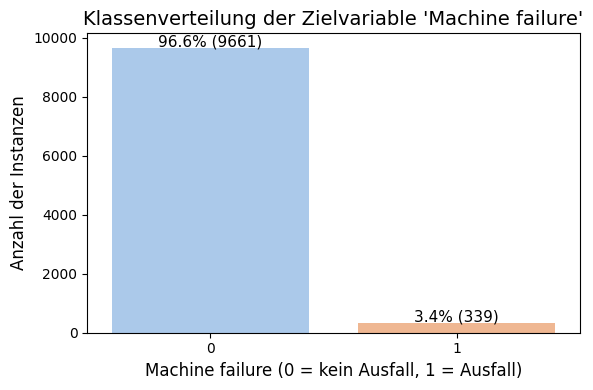

In [2]:
# Klassenverteilung berechnen
class_counts = df['Machine failure'].value_counts()
class_percent = class_counts / class_counts.sum() * 100
class_df = pd.DataFrame({
    'Failure': class_counts.index,
    'Count': class_counts.values,
    'Percent': class_percent.values
})

# Visualisierung
plt.figure(figsize=(6, 4))
sns.barplot(data=class_df, x="Failure", y="Count", hue="Failure", palette="pastel", legend=False)

# Achsenbeschriftung und Titel
plt.title("Klassenverteilung der Zielvariable 'Machine failure'", fontsize=14)
plt.xlabel("Machine failure (0 = kein Ausfall, 1 = Ausfall)", fontsize=12)
plt.ylabel("Anzahl der Instanzen", fontsize=12)

# Prozent und absolutwerte über den Balken anzeigen
for i, row in class_df.iterrows():
    label = f"{row['Percent']:.1f}% ({int(row['Count'])})"
    plt.text(i, row["Count"] + 50, label, ha='center', fontsize=11)

plt.tight_layout()
plt.show()


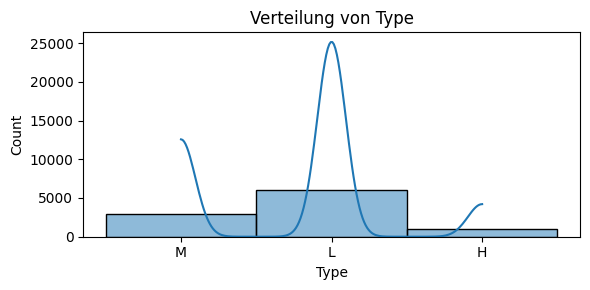

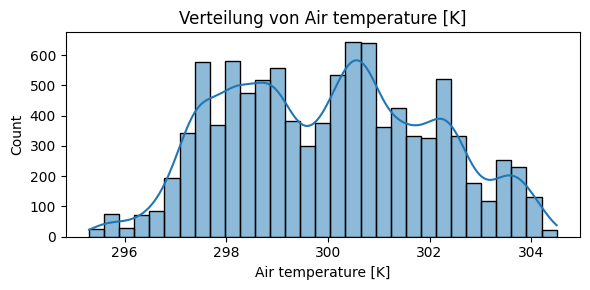

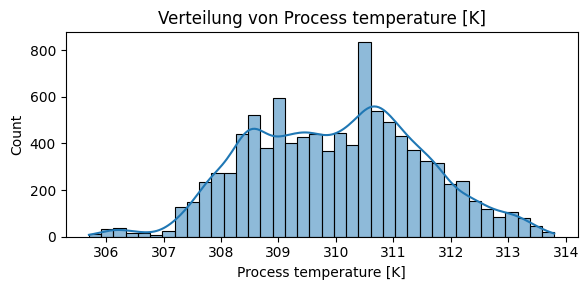

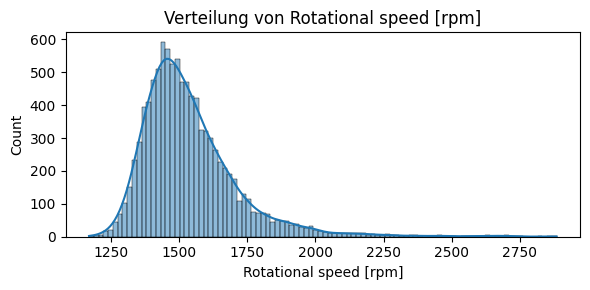

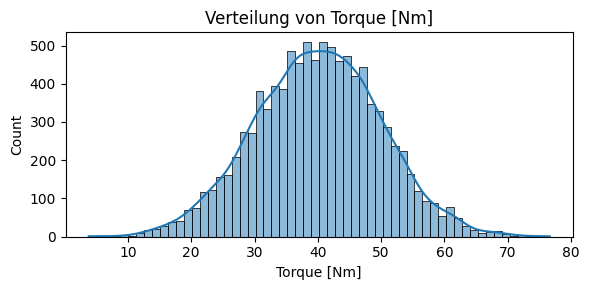

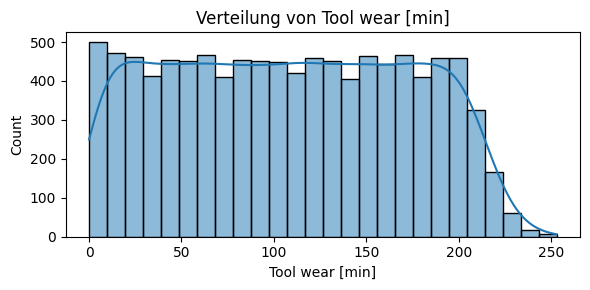

In [3]:
num_cols = ['Type','Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Verteilung von {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

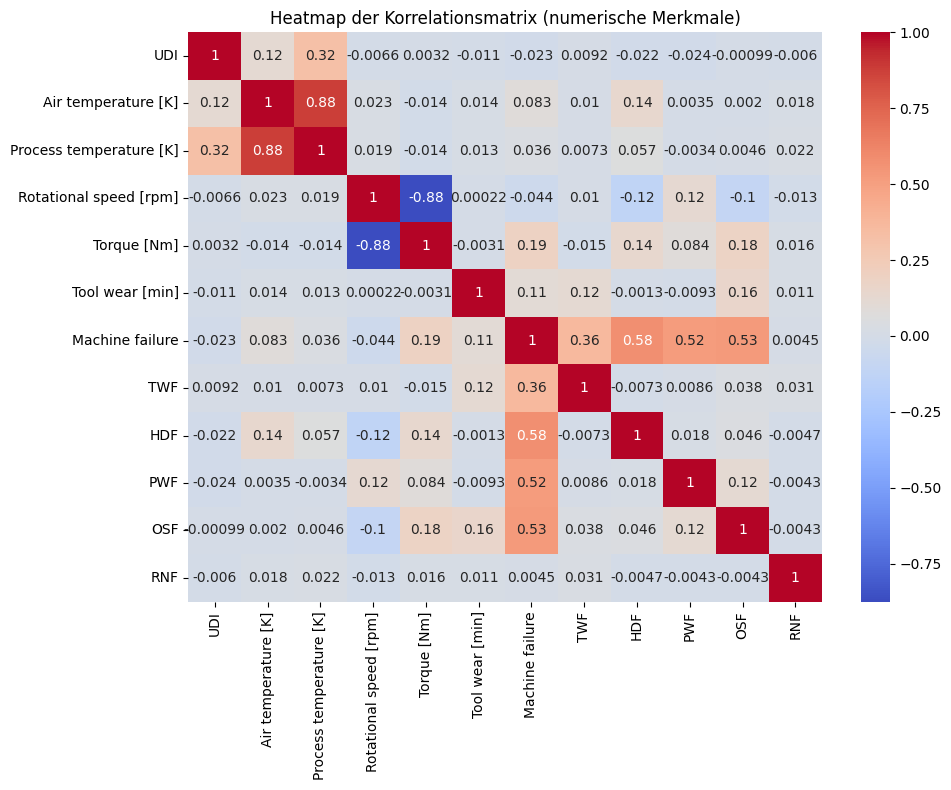

In [5]:
# Korrelation (numerischer Merkmale) Berechnung und Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only= 'True'), annot=True, cmap='coolwarm')
plt.title("Heatmap der Korrelationsmatrix (numerische Merkmale)")
plt.tight_layout()
plt.show()

Machine failure     0    1
Type                      
H                 982   21
L                5765  235
M                2914   83
Machine failure          0         1
Type                                
H                97.906281  2.093719
L                96.083333  3.916667
M                97.230564  2.769436


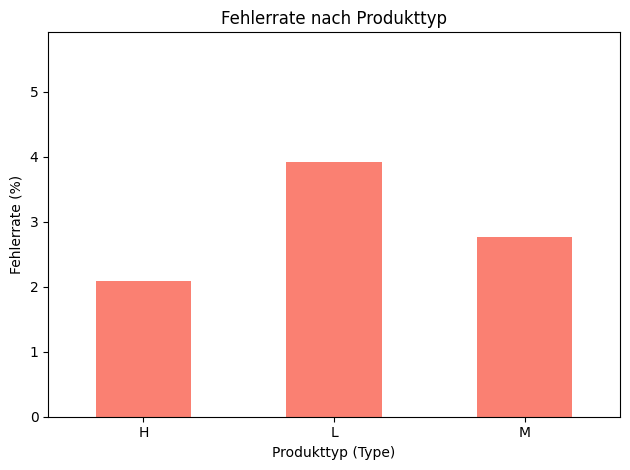

In [6]:
# Anzahl Fehler pro Produkttyp
type_failure_counts = pd.crosstab(df['Type'], df['Machine failure'])
print(type_failure_counts)

# Prozentuale Fehlerrate pro Produkttyp
type_failure_percent = pd.crosstab(df['Type'], df['Machine failure'], normalize='index') * 100
print(type_failure_percent)

# Balkendiagramm mit relativen Fehlerraten
type_failure_percent[1].plot(kind='bar', color='salmon')
plt.title("Fehlerrate nach Produkttyp")
plt.xlabel("Produkttyp (Type)")
plt.ylabel("Fehlerrate (%)")
plt.ylim(0, type_failure_percent[1].max() + 2)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


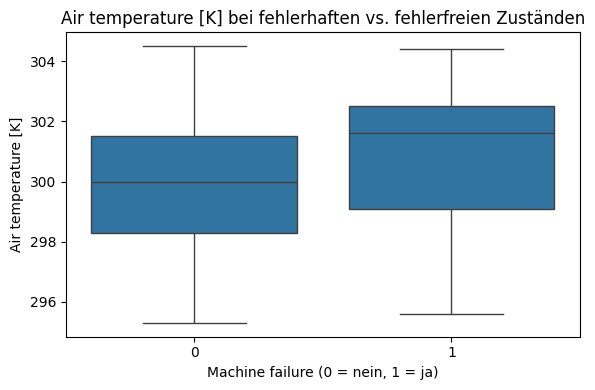

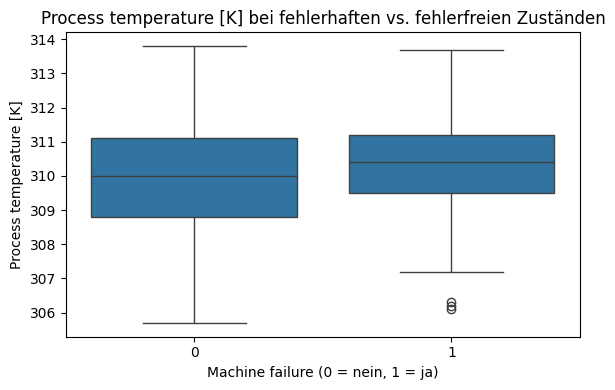

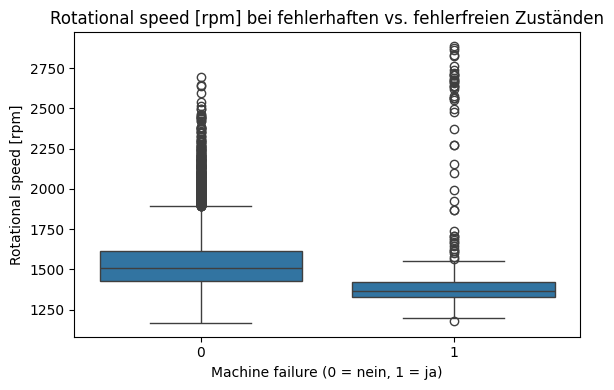

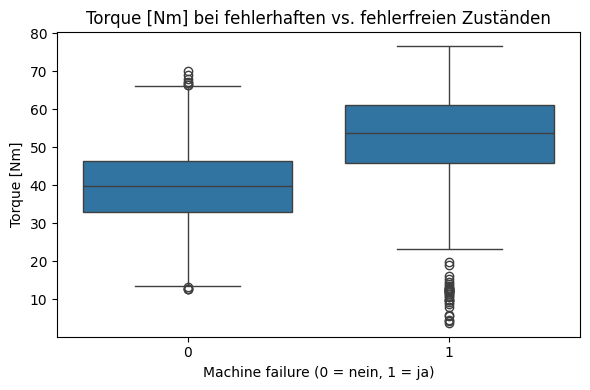

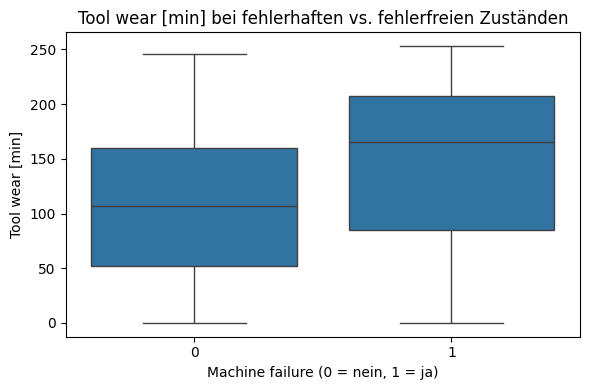

Machine failure,0,1
Air temperature [K],300.0,301.6
Process temperature [K],310.0,310.4
Rotational speed [rpm],1507.0,1365.0
Torque [Nm],39.9,53.7
Tool wear [min],107.0,165.0


In [18]:
num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Machine failure', y=col, data=df)
    plt.title(f"{col} bei fehlerhaften vs. fehlerfreien Zuständen")
    plt.xlabel("Machine failure (0 = nein, 1 = ja)")
    plt.tight_layout()
    plt.show()

df.groupby('Machine failure')[num_cols].median().T



,Fehlerfrei (0),Fehler (1)
Temp_Diff,9.80,9.30
Tool_wear_margin,133.00,75.00
Torque_per_rpm,0.03,0.04
active_errors,0.00,1.00


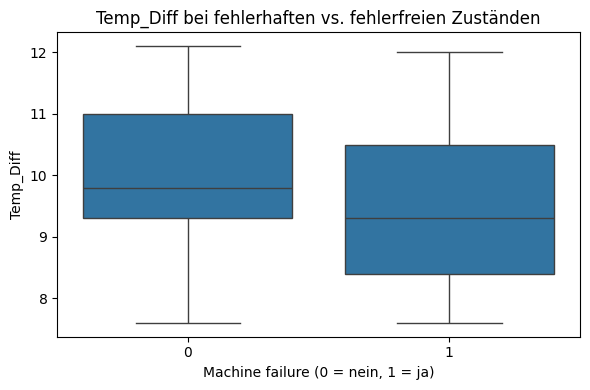

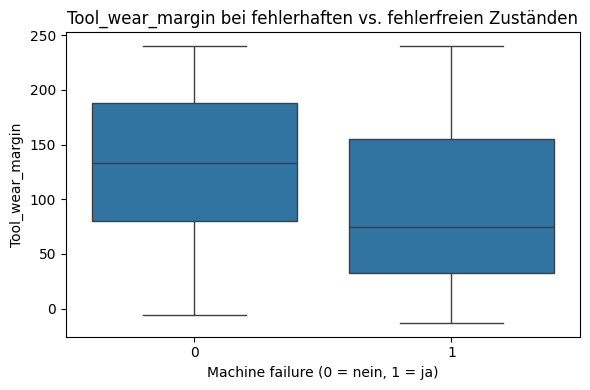

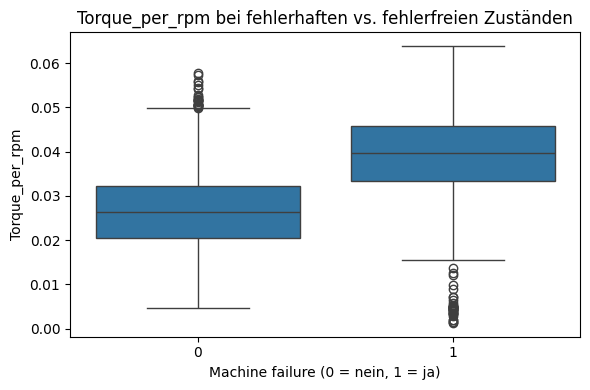

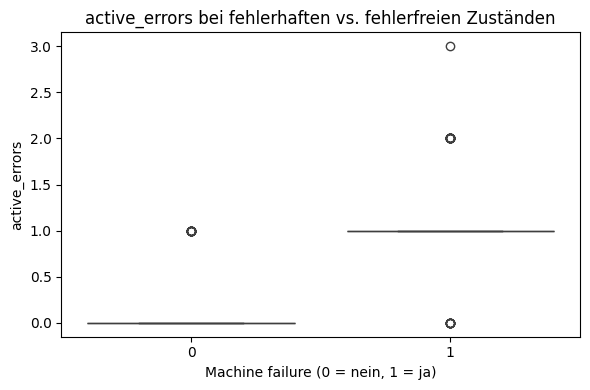

In [23]:
# Temperaturdifferenz
df['Temp_Diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

# Verschleißreserve (240 min als Schwelle)
df['Tool_wear_margin'] = 240 - df['Tool wear [min]']

# Belastung pro Umdrehung (Achtung auf Division durch 0)
df['Torque_per_rpm'] = df['Torque [Nm]'] / df['Rotational speed [rpm]']

# Anzahl gleichzeitig aktiver Fehlerarten
df['active_errors'] = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)

# Liste der neuen Features
diff_features = ['Temp_Diff', 'Tool_wear_margin', 'Torque_per_rpm', 'active_errors']

# Gruppierte Zusammenfassung (Median pro Klasse)
summary_df = df.groupby('Machine failure')[diff_features].median().T
# Optional: Spalten umbenennen für Klarheit
summary_df.columns = ['Fehlerfrei (0)', 'Fehler (1)']
summary_df = summary_df.round(2)  # auf 2 Nachkommastellen runden
# Visualisierung Zusammenfassung
display(summary_df)

# Boxplots für alle Differenzmetriken
for feature in diff_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Machine failure', y=feature, data=df)
    plt.title(f"{feature} bei fehlerhaften vs. fehlerfreien Zuständen")
    plt.xlabel("Machine failure (0 = nein, 1 = ja)")
    plt.tight_layout()
    plt.show()